In [1]:
import numpy as np
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.constants import mu_0
from scipy.constants import elementary_charge as q_e
from scipy.constants import proton_mass as m_i
from astropy.convolution import convolve, convolve_fft
from scipy.signal import fftconvolve
from scipy.interpolate import SmoothBivariateSpline
import write_canonical_flux_tube_quantities as wcf
reload(wcf)

from datetime import date
from datetime import datetime
import visit_writer

import structured_3d_vtk as struc_3d
reload(struc_3d)

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

import os

import ion_current_to_mach_number as ic_to_mach
reload(ic_to_mach)

import read_from_sql

from mpl_toolkits.mplot3d import Axes3D

# Read idl files and generate inteprolators

In [2]:
bx_all_planes = wcf.save_idl_quantity_to_unstructured_grids('bx', 'B_x', 'now',
                                                            x_min=-0.032, x_max=0.028,
                                                            y_min=-0.022, y_max=0.032, 
                                                            z_min=0.249, z_max=0.416)
by_all_planes = wcf.save_idl_quantity_to_unstructured_grids('by', 'B_y', 'now',
                                                            x_min=-0.032, x_max=0.028,
                                                            y_min=-0.022, y_max=0.032, 
                                                            z_min=0.249, z_max=0.416)
bz_all_planes = wcf.save_idl_quantity_to_unstructured_grids('bz', 'B_z', 'now',
                                                            x_min=-0.032, x_max=0.028,
                                                            y_min=-0.022, y_max=0.032, 
                                                            z_min=0.249, z_max=0.416)
te_all_planes = wcf.save_idl_quantity_to_unstructured_grids('te', 'T_e', 'now', 
                                                            x_min=-0.026, x_max=0.028,
                                                            y_min=-0.03, y_max=0.028, 
                                                            z_min=0.249, z_max=0.416,
                                                            bounds=(1e-3, 1e3))
n_all_planes = wcf.save_idl_quantity_to_unstructured_grids('n', 'n', 'now',
                                                           x_min=-0.026, x_max=0.028,
                                                           y_min=-0.03, y_max=0.028, 
                                                           z_min=0.249, z_max=0.416,
                                                           bounds=(1e3, 1e22))
n_three_planes = wcf.remove_plane(0.302, n_all_planes)
te_three_planes = wcf.remove_plane(0.302, te_all_planes)

n_all_planes = n_three_planes
te_all_planes = te_three_planes

bx_triangulation, bx_interpolators = wcf.give_delaunay_and_interpolator(bx_all_planes)
by_triangulation, by_interpolators = wcf.give_delaunay_and_interpolator(by_all_planes)
bz_triangulation, bz_interpolators = wcf.give_delaunay_and_interpolator(bz_all_planes)
te_triangulation, te_interpolators = wcf.give_delaunay_and_interpolator(te_all_planes)
n_triangulation, n_interpolators = wcf.give_delaunay_and_interpolator(n_all_planes)

# Read Mach measurements from database and build interpolators

In [3]:
timesteps = 250

database = '/home/jensv/rsx/jens_analysis/shots_database/source/shots.db'
table = 'Shots'
z_direction_1, z_direction_2 = 0, 180
y_direction_1, y_direction_2 = 90, 270
angle_signs = {0: 1,
               180: -1,
               90: -1,
               0: 1}
min_spectral_density = 1.6e-8

condition_z_0416 = ("campaigns = 'mach_probe_plane_campaign_1'"
                    " AND fiducial_pre_crowbar_gyration_spectral_density > "
                    + str(min_spectral_density) +
                    " AND mach_signals_exist = 1"
                    " AND (mach_orientation = " + str(z_direction_1) +
                    " OR mach_orientation = " + str(z_direction_2) + ")")

condition_y_0416 = ("campaigns = 'mach_probe_plane_campaign_1'"
                    " AND fiducial_pre_crowbar_gyration_spectral_density > "
                    + str(min_spectral_density) +
                    " AND mach_signals_exist = 1"
                    " AND (mach_orientation = " + str(y_direction_1) +
                    " OR mach_orientation = " + str(y_direction_2) + ")")

cursor, connection = read_from_sql.cursor_with_rows(condition_z_0416,
                                                    database,
                                                    table)
z_0416_shots = cursor.fetchall()
cursor.close()
connection.close()

cursor, connection = read_from_sql.cursor_with_rows(condition_y_0416,
                                                    database,
                                                    table)
y_0416_shots = cursor.fetchall()
cursor.close()
connection.close()

condition_z_302 = ("campaigns = 'mach_probe_plane_campaign_2'"
                   " AND fiducial_pre_crowbar_gyration_spectral_density > "
                   + str(min_spectral_density) +
                   " AND mach_signals_exist = 1"
                   " AND (mach_orientation = " + str(z_direction_1) +
                   " OR mach_orientation = " + str(z_direction_2) + ")")

cursor, connection = read_from_sql.cursor_with_rows(condition_z_302,
                                                    database,
                                                    table)
z_0302_shots = cursor.fetchall()
cursor.close()
connection.close()

mach_z_0416_measurements = ic_to_mach.run_mach_analysis(z_0416_shots,
                                                        timesteps, 
                                                        angle_signs) 
mach_y_0416_measurements = ic_to_mach.run_mach_analysis(y_0416_shots,
                                                        timesteps, 
                                                        angle_signs)
mach_z_0302_measurements = ic_to_mach.run_mach_analysis(z_0302_shots,
                                                        timesteps, 
                                                        angle_signs)

mach_z_0416_measurements['delays'] = np.arange(timesteps)
mach_y_0416_measurements['delays'] = np.arange(timesteps)
mach_z_0302_measurements['delays'] = np.arange(timesteps)

mach_z_0416_measurements = struc_3d.average_duplicate_points(mach_z_0416_measurements)
mach_y_0416_measurements = struc_3d.average_duplicate_points(mach_y_0416_measurements)
mach_z_0302_measurements = struc_3d.average_duplicate_points(mach_z_0302_measurements)

mach_y_measurements = {0.416: mach_y_0416_measurements}
mach_z_measurements = {0.302: mach_z_0302_measurements,
                       0.416: mach_z_0416_measurements}

mach_y_all_planes = wcf.save_quantity_to_unstructured_grids(mach_y_measurements, 
                                                            'Mach_y', 'Mach_y', '2016-07-26',
                                                            planes=[0.416],
                                                            x_min=-0.052, x_max=0.052,
                                                            y_min=-0.022, y_max=0.032, 
                                                            z_min=0.249, z_max=0.416,
                                                            bounds=(-10, 10))

mach_z_all_planes = wcf.save_quantity_to_unstructured_grids(mach_z_measurements, 
                                                            'Mach_z', 'Mach_z', '2016-07-26',
                                                            planes=[0.302, 0.416],
                                                            x_min=-0.032, x_max=0.032,
                                                            y_min=-0.022, y_max=0.032, 
                                                            z_min=0.249, z_max=0.416,
                                                            bounds=(-10, 10))
mach_y_all_planes = wcf.remove_nan_points(mach_y_all_planes)
mach_z_all_planes = wcf.remove_nan_points(mach_z_all_planes)

mach_y_triangulation, mach_y_interpolators = wcf.give_delaunay_and_interpolator(mach_y_all_planes)
mach_z_triangulation, mach_z_interpolators = wcf.give_delaunay_and_interpolator(mach_z_all_planes)

# Just work on timestep 0

In [4]:
time_point = 0

# Interpolate Temperature and density

In [5]:
(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mesh_wo_edges = wcf.remove_edges_mesh([np.array(mesh[0]), 
                                       np.array(mesh[1]), 
                                       np.array(mesh[2])])
ones = np.ones(mesh_wo_edges[0].shape)


te_interpolator = te_interpolators[time_point]
n_interpolator = n_interpolators[time_point]
    
temperature = wcf.scalar_on_mesh(te_interpolator, mesh_wo_edges)
density = wcf.scalar_on_mesh(n_interpolator, mesh_wo_edges)
b_field, b_field_norm = wcf.b_field_on_mesh([bx_interpolators[time_point], 
                                             by_interpolators[time_point],
                                             bz_interpolators[time_point]], 
                                             mesh_wo_edges, 
                                             bias=2e-2)

In [6]:
temperature_plane_normalized = temperature / np.nanmax(np.nanmax(temperature, 0), 0)[None, None, :]

# Determine measured ion_velocity u_i

In [7]:
(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mach_y_interpolator = mach_y_interpolators[time_point]
mach_z_interpolator = mach_z_interpolators[time_point]
te_interpolator = te_interpolators[time_point]
 
mach_y = wcf.scalar_on_mesh(mach_y_interpolator, mesh[:2])
mach_z = wcf.scalar_on_mesh(mach_z_interpolator, mesh)
te = wcf.scalar_on_mesh(te_interpolator, mesh)

u_i_y = np.sqrt(te*q_e/m_i)*mach_y
u_i_z = np.sqrt(te*q_e/m_i)*mach_z

u_i_y = np.reshape(u_i_y, mesh[0].shape)
u_i_z = np.reshape(u_i_z, mesh[0].shape)

u_i_y = wcf.remove_edges_scalar_quantity_meshes(u_i_y)
u_i_z = wcf.remove_edges_scalar_quantity_meshes(u_i_z)

In [21]:
y_index = np.arange(250)
x_index = np.roll(y_index, -63)

In [22]:
y_index

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [23]:
x_index

array([ 63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 24

# $u_{ix} = u_{iy}(t + 0.25 \tau)$

In [30]:
time_point = 0

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mesh_wo_edges = wcf.remove_edges_mesh([np.array(mesh[0]), 
                                       np.array(mesh[1]), 
                                       np.array(mesh[2])])
ones = np.ones(mesh_wo_edges[0].shape)


te_interpolator = te_interpolators[time_point]
n_interpolator = n_interpolators[time_point]
    
temperature = wcf.scalar_on_mesh(te_interpolator, mesh_wo_edges)
density = wcf.scalar_on_mesh(n_interpolator, mesh_wo_edges)
b_field, b_field_norm = wcf.b_field_on_mesh([bx_interpolators[time_point], 
                                             by_interpolators[time_point],
                                             bz_interpolators[time_point]], 
                                             mesh_wo_edges, 
                                             bias=2e-2)

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mach_y_interpolator = mach_y_interpolators[time_point]
mach_z_interpolator = mach_z_interpolators[time_point]
te_interpolator = te_interpolators[time_point]
 
mach_y = wcf.scalar_on_mesh(mach_y_interpolator, mesh[:2])
mach_z = wcf.scalar_on_mesh(mach_z_interpolator, mesh)
te = wcf.scalar_on_mesh(te_interpolator, mesh)

u_i_y = np.sqrt(te*q_e/m_i)*mach_y
u_i_z = np.sqrt(te*q_e/m_i)*mach_z

u_i_y = np.reshape(u_i_y, mesh[0].shape)
u_i_z = np.reshape(u_i_z, mesh[0].shape)

u_i_y = wcf.remove_edges_scalar_quantity_meshes(u_i_y)
u_i_z = wcf.remove_edges_scalar_quantity_meshes(u_i_z)


### u_i_x
###
time_point = 63

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mesh_wo_edges = wcf.remove_edges_mesh([np.array(mesh[0]), 
                                       np.array(mesh[1]), 
                                       np.array(mesh[2])])
ones = np.ones(mesh_wo_edges[0].shape)


te_interpolator = te_interpolators[time_point]
n_interpolator = n_interpolators[time_point]
    
temperature = wcf.scalar_on_mesh(te_interpolator, mesh_wo_edges)
density = wcf.scalar_on_mesh(n_interpolator, mesh_wo_edges)
b_field, b_field_norm = wcf.b_field_on_mesh([bx_interpolators[time_point], 
                                             by_interpolators[time_point],
                                             bz_interpolators[time_point]], 
                                             mesh_wo_edges, 
                                             bias=2e-2)

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mach_y_interpolator = mach_y_interpolators[time_point]
mach_z_interpolator = mach_z_interpolators[time_point]
te_interpolator = te_interpolators[time_point]
 
mach_y = wcf.scalar_on_mesh(mach_y_interpolator, mesh[:2])
mach_z = wcf.scalar_on_mesh(mach_z_interpolator, mesh)
te = wcf.scalar_on_mesh(te_interpolator, mesh)

u_i_x = np.sqrt(te*q_e/m_i)*mach_y

u_i_x = np.reshape(u_i_x, mesh[0].shape)

u_i_x = wcf.remove_edges_scalar_quantity_meshes(u_i_x)

In [17]:
249-187

62

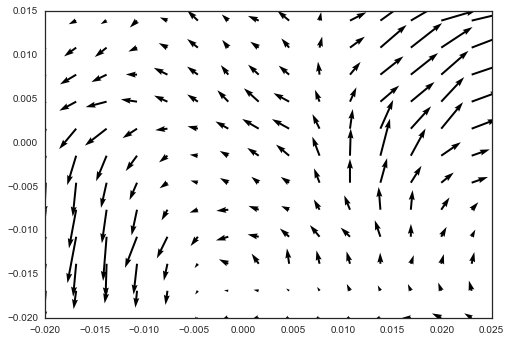

In [34]:
plt.quiver(mesh_wo_edges[0][:,:,-1][::3, ::3], mesh_wo_edges[1][:,:,-1][::3, ::3],
           u_i_x[:,:,-1][::3, ::3], u_i_y[:,:,-1][::3, ::3])

# $u_{ix} = u_{iy}(t - 0.25 \tau)$

In [39]:
time_point = 0

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mesh_wo_edges = wcf.remove_edges_mesh([np.array(mesh[0]), 
                                       np.array(mesh[1]), 
                                       np.array(mesh[2])])
ones = np.ones(mesh_wo_edges[0].shape)


te_interpolator = te_interpolators[time_point]
n_interpolator = n_interpolators[time_point]
    
temperature = wcf.scalar_on_mesh(te_interpolator, mesh_wo_edges)
density = wcf.scalar_on_mesh(n_interpolator, mesh_wo_edges)
b_field, b_field_norm = wcf.b_field_on_mesh([bx_interpolators[time_point], 
                                             by_interpolators[time_point],
                                             bz_interpolators[time_point]], 
                                             mesh_wo_edges, 
                                             bias=2e-2)

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mach_y_interpolator = mach_y_interpolators[time_point]
mach_z_interpolator = mach_z_interpolators[time_point]
te_interpolator = te_interpolators[time_point]
 
mach_y = wcf.scalar_on_mesh(mach_y_interpolator, mesh[:2])
mach_z = wcf.scalar_on_mesh(mach_z_interpolator, mesh)
te = wcf.scalar_on_mesh(te_interpolator, mesh)

u_i_y = np.sqrt(te*q_e/m_i)*mach_y
u_i_z = np.sqrt(te*q_e/m_i)*mach_z

u_i_y = np.reshape(u_i_y, mesh[0].shape)
u_i_z = np.reshape(u_i_z, mesh[0].shape)

u_i_y = wcf.remove_edges_scalar_quantity_meshes(u_i_y)
u_i_z = wcf.remove_edges_scalar_quantity_meshes(u_i_z)


### u_i_x
###
time_point = 187

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mesh_wo_edges = wcf.remove_edges_mesh([np.array(mesh[0]), 
                                       np.array(mesh[1]), 
                                       np.array(mesh[2])])
ones = np.ones(mesh_wo_edges[0].shape)


te_interpolator = te_interpolators[time_point]
n_interpolator = n_interpolators[time_point]
    
temperature = wcf.scalar_on_mesh(te_interpolator, mesh_wo_edges)
density = wcf.scalar_on_mesh(n_interpolator, mesh_wo_edges)
b_field, b_field_norm = wcf.b_field_on_mesh([bx_interpolators[time_point], 
                                             by_interpolators[time_point],
                                             bz_interpolators[time_point]], 
                                             mesh_wo_edges, 
                                             bias=2e-2)

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mach_y_interpolator = mach_y_interpolators[time_point]
mach_z_interpolator = mach_z_interpolators[time_point]
te_interpolator = te_interpolators[time_point]
 
mach_y = wcf.scalar_on_mesh(mach_y_interpolator, mesh[:2])
mach_z = wcf.scalar_on_mesh(mach_z_interpolator, mesh)
te = wcf.scalar_on_mesh(te_interpolator, mesh)

u_i_x = np.sqrt(te*q_e/m_i)*mach_y

u_i_x = np.reshape(u_i_x, mesh[0].shape)

u_i_x = wcf.remove_edges_scalar_quantity_meshes(u_i_x)

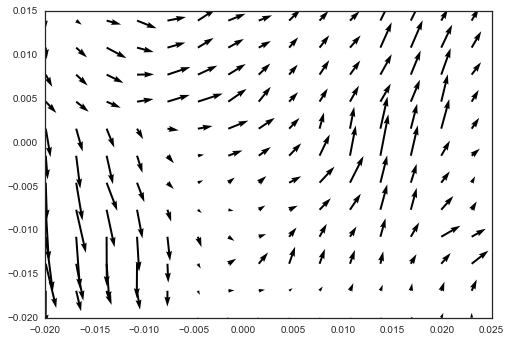

In [40]:
plt.quiver(mesh_wo_edges[0][:,:,-1][::3, ::3], mesh_wo_edges[1][:,:,-1][::3, ::3],
           u_i_x[:,:,-1][::3, ::3], u_i_y[:,:,-1][::3, ::3])

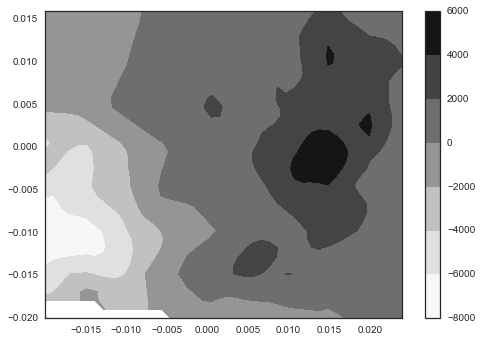

In [43]:
plt.contourf(mesh_wo_edges[0][:,:,-1], mesh_wo_edges[1][:,:,-1],
             u_i_y[:,:,-1])
plt.colorbar()

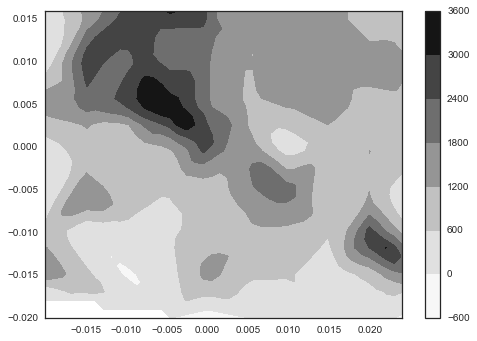

In [46]:
plt.contourf(mesh_wo_edges[0][:,:,-1], mesh_wo_edges[1][:,:,-1],
             u_i_x[:,:,-1])
plt.colorbar()

In [48]:
time_point = 0

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mesh_wo_edges = wcf.remove_edges_mesh([np.array(mesh[0]), 
                                       np.array(mesh[1]), 
                                       np.array(mesh[2])])
ones = np.ones(mesh_wo_edges[0].shape)


te_interpolator = te_interpolators[time_point]
n_interpolator = n_interpolators[time_point]
    
temperature = wcf.scalar_on_mesh(te_interpolator, mesh_wo_edges)
density = wcf.scalar_on_mesh(n_interpolator, mesh_wo_edges)
b_field, b_field_norm = wcf.b_field_on_mesh([bx_interpolators[time_point], 
                                             by_interpolators[time_point],
                                             bz_interpolators[time_point]], 
                                             mesh_wo_edges, 
                                             bias=2e-2)

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mach_y_interpolator = mach_y_interpolators[time_point]
mach_z_interpolator = mach_z_interpolators[time_point]
te_interpolator = te_interpolators[time_point]
 
mach_y = wcf.scalar_on_mesh(mach_y_interpolator, mesh[:2])
mach_z = wcf.scalar_on_mesh(mach_z_interpolator, mesh)
te = wcf.scalar_on_mesh(te_interpolator, mesh)

u_i_y = np.sqrt(te*q_e/m_i)*mach_y
u_i_z = np.sqrt(te*q_e/m_i)*mach_z

u_i_y = np.reshape(u_i_y, mesh[0].shape)
u_i_z = np.reshape(u_i_z, mesh[0].shape)

u_i_y = wcf.remove_edges_scalar_quantity_meshes(u_i_y)
u_i_z = wcf.remove_edges_scalar_quantity_meshes(u_i_z)


### u_i_x
###
mach_x_time_point = 187

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mesh_wo_edges = wcf.remove_edges_mesh([np.array(mesh[0]), 
                                       np.array(mesh[1]), 
                                       np.array(mesh[2])])
ones = np.ones(mesh_wo_edges[0].shape)


te_interpolator = te_interpolators[time_point]
n_interpolator = n_interpolators[time_point]
    
temperature = wcf.scalar_on_mesh(te_interpolator, mesh_wo_edges)
density = wcf.scalar_on_mesh(n_interpolator, mesh_wo_edges)
b_field, b_field_norm = wcf.b_field_on_mesh([bx_interpolators[time_point], 
                                             by_interpolators[time_point],
                                             bz_interpolators[time_point]], 
                                             mesh_wo_edges, 
                                             bias=2e-2)

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mach_y_interpolator = mach_y_interpolators[mach_x_time_point]
mach_z_interpolator = mach_z_interpolators[mach_x_time_point]
te_interpolator = te_interpolators[time_point]
 
mach_y = wcf.scalar_on_mesh(mach_y_interpolator, mesh[:2])
mach_z = wcf.scalar_on_mesh(mach_z_interpolator, mesh)
te = wcf.scalar_on_mesh(te_interpolator, mesh)

u_i_x = np.sqrt(te*q_e/m_i)*mach_y

u_i_x = np.reshape(u_i_x, mesh[0].shape)

u_i_x = wcf.remove_edges_scalar_quantity_meshes(u_i_x)

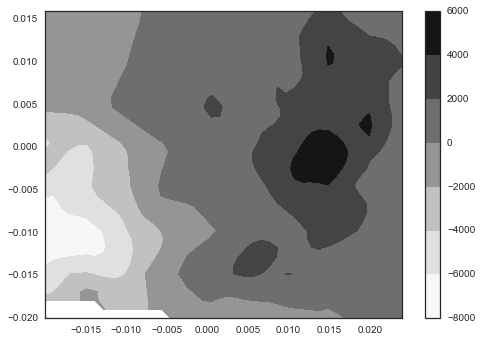

In [49]:
plt.contourf(mesh_wo_edges[0][:,:,-1], mesh_wo_edges[1][:,:,-1],
             u_i_y[:,:,-1])
plt.colorbar()

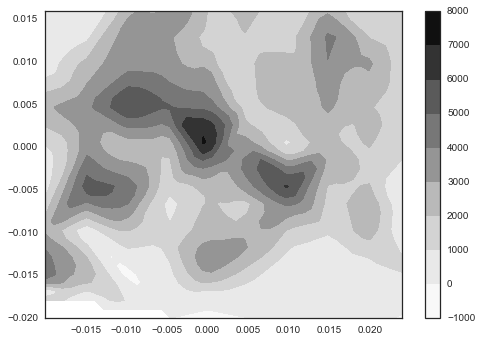

In [50]:
plt.contourf(mesh_wo_edges[0][:,:,-1], mesh_wo_edges[1][:,:,-1],
             u_i_x[:,:,-1])
plt.colorbar()

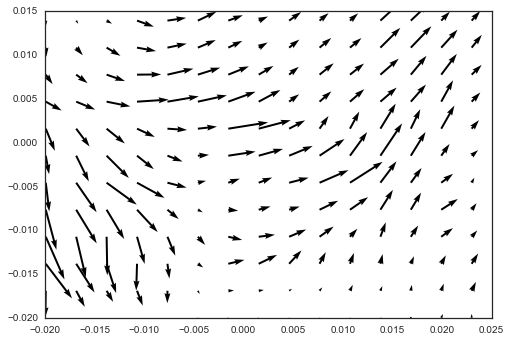

In [51]:
plt.quiver(mesh_wo_edges[0][:,:,-1][::3, ::3], mesh_wo_edges[1][:,:,-1][::3, ::3],
           u_i_x[:,:,-1][::3, ::3], u_i_y[:,:,-1][::3, ::3])

In [97]:
time_point = 0

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mesh_wo_edges = wcf.remove_edges_mesh([np.array(mesh[0]), 
                                       np.array(mesh[1]), 
                                       np.array(mesh[2])])
ones = np.ones(mesh_wo_edges[0].shape)


te_interpolator = te_interpolators[time_point]
n_interpolator = n_interpolators[time_point]
    
temperature = wcf.scalar_on_mesh(te_interpolator, mesh_wo_edges)
density = wcf.scalar_on_mesh(n_interpolator, mesh_wo_edges)
b_field, b_field_norm = wcf.b_field_on_mesh([bx_interpolators[time_point], 
                                             by_interpolators[time_point],
                                             bz_interpolators[time_point]], 
                                             mesh_wo_edges, 
                                             bias=2e-2)

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mach_y_interpolator = mach_y_interpolators[time_point]
mach_z_interpolator = mach_z_interpolators[time_point]
te_interpolator = te_interpolators[time_point]
 
mach_y = wcf.scalar_on_mesh(mach_y_interpolator, mesh[:2])
mach_z = wcf.scalar_on_mesh(mach_z_interpolator, mesh)
te = wcf.scalar_on_mesh(te_interpolator, mesh)
te = wcf.boxcar_filter_quantity_mesh(te, 15)

u_i_y = np.sqrt(te*q_e/m_i)*mach_y
u_i_z = np.sqrt(te*q_e/m_i)*mach_z

u_i_y = np.reshape(u_i_y, mesh[0].shape)
u_i_z = np.reshape(u_i_z, mesh[0].shape)

u_i_y = wcf.remove_edges_scalar_quantity_meshes(u_i_y)
u_i_z = wcf.remove_edges_scalar_quantity_meshes(u_i_z)


### u_i_x
###
mach_x_time_point = 187

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mesh_wo_edges = wcf.remove_edges_mesh([np.array(mesh[0]), 
                                       np.array(mesh[1]), 
                                       np.array(mesh[2])])
ones = np.ones(mesh_wo_edges[0].shape)


te_interpolator = te_interpolators[time_point]
n_interpolator = n_interpolators[time_point]
    
temperature = wcf.scalar_on_mesh(te_interpolator, mesh_wo_edges)
density = wcf.scalar_on_mesh(n_interpolator, mesh_wo_edges)
b_field, b_field_norm = wcf.b_field_on_mesh([bx_interpolators[time_point], 
                                             by_interpolators[time_point],
                                             bz_interpolators[time_point]], 
                                             mesh_wo_edges, 
                                             bias=2e-2)

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mach_y_interpolator = mach_y_interpolators[mach_x_time_point]
mach_z_interpolator = mach_z_interpolators[mach_x_time_point]
te_interpolator = te_interpolators[time_point]
 
mach_y = wcf.scalar_on_mesh(mach_y_interpolator, mesh[:2])
mach_z = wcf.scalar_on_mesh(mach_z_interpolator, mesh)
te = wcf.scalar_on_mesh(te_interpolator, mesh)
te = wcf.boxcar_filter_quantity_mesh(te, 15)

u_i_x = np.sqrt(te*q_e/m_i)*mach_y

u_i_x = np.reshape(u_i_x, mesh[0].shape)

u_i_x = wcf.remove_edges_scalar_quantity_meshes(u_i_x)

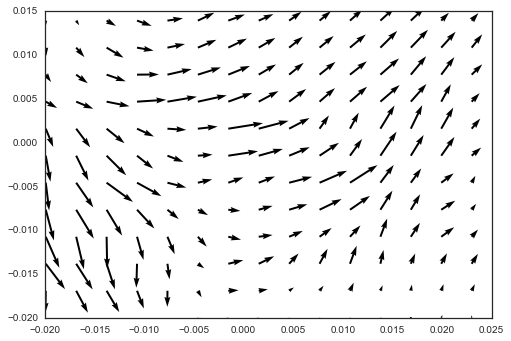

In [98]:
plt.quiver(mesh_wo_edges[0][:,:,-1][::3, ::3], mesh_wo_edges[1][:,:,-1][::3, ::3],
           u_i_x[:,:,-1][::3, ::3], u_i_y[:,:,-1][::3, ::3])

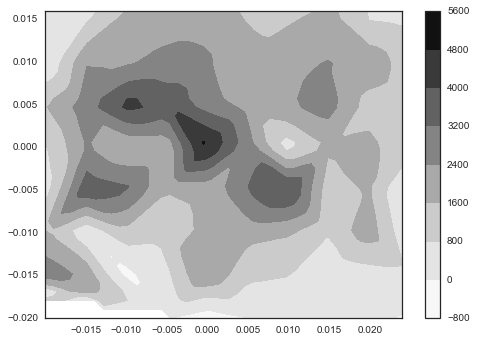

In [99]:
plt.contourf(mesh_wo_edges[0][:,:,-1], mesh_wo_edges[1][:,:,-1],
             u_i_x[:,:,-1])
plt.colorbar()

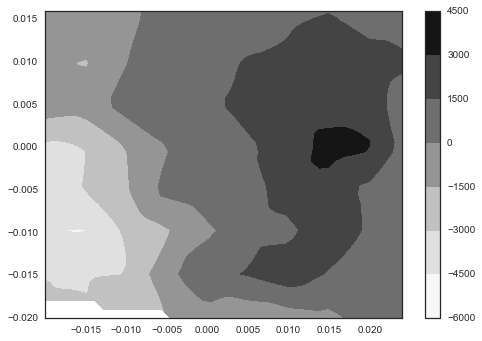

In [100]:
plt.contourf(mesh_wo_edges[0][:,:,-1], mesh_wo_edges[1][:,:,-1],
             u_i_y[:,:,-1])
plt.colorbar()

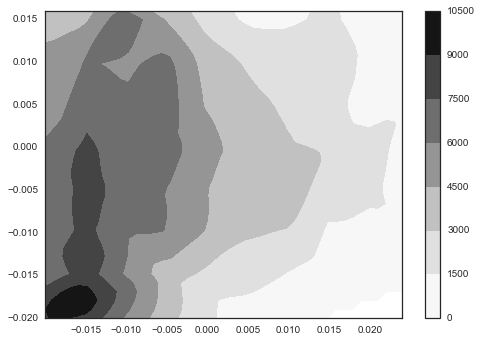

In [101]:
plt.contourf(mesh_wo_edges[0][:,:,-1], mesh_wo_edges[1][:,:,-1],
             u_i_z[:,:,-1])
plt.colorbar()

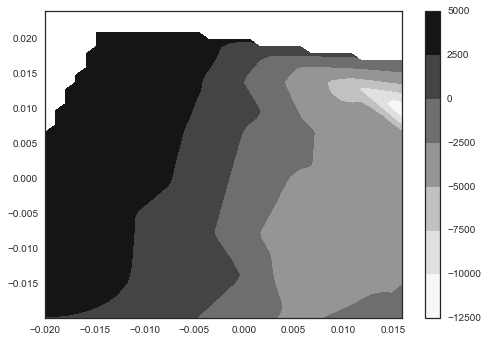

In [102]:
plt.contourf(mesh_wo_edges[1][:,:,-1], mesh_wo_edges[0][:,:,-1],
             u_i_z[:,:,53])
plt.colorbar()

# How reasonable does line interpolating across the two mach_z plane measurements seem?
# Can I use the same line with slope porportional to the mach_y/mach_z ratio and adjusted y_0 for the y and x direction?

In [129]:
time_point = 0

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mesh_wo_edges = wcf.remove_edges_mesh([np.array(mesh[0]), 
                                       np.array(mesh[1]), 
                                       np.array(mesh[2])])
ones = np.ones(mesh_wo_edges[0].shape)


te_interpolator = te_interpolators[time_point]
n_interpolator = n_interpolators[time_point]
    
temperature = wcf.scalar_on_mesh(te_interpolator, mesh_wo_edges)
density = wcf.scalar_on_mesh(n_interpolator, mesh_wo_edges)
b_field, b_field_norm = wcf.b_field_on_mesh([bx_interpolators[time_point], 
                                             by_interpolators[time_point],
                                             bz_interpolators[time_point]], 
                                             mesh_wo_edges, 
                                             bias=2e-2)

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mach_y_interpolator = mach_y_interpolators[time_point]
mach_z_interpolator = mach_z_interpolators[time_point]
te_interpolator = te_interpolators[time_point]
 
mach_y = wcf.scalar_on_mesh(mach_y_interpolator, mesh[:2])
mach_z = wcf.scalar_on_mesh(mach_z_interpolator, mesh)
te = wcf.scalar_on_mesh(te_interpolator, mesh)
te = wcf.boxcar_filter_quantity_mesh(te, 15)

u_i_y = np.sqrt(te*q_e/m_i)*mach_y
u_i_z = np.sqrt(te*q_e/m_i)*mach_z

u_i_y = np.reshape(u_i_y, mesh[0].shape)
u_i_z = np.reshape(u_i_z, mesh[0].shape)

u_i_y = wcf.remove_edges_scalar_quantity_meshes(u_i_y)
u_i_z = wcf.remove_edges_scalar_quantity_meshes(u_i_z)


### u_i_x
###
mach_x_time_point = 187

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mesh_wo_edges = wcf.remove_edges_mesh([np.array(mesh[0]), 
                                       np.array(mesh[1]), 
                                       np.array(mesh[2])])
ones = np.ones(mesh_wo_edges[0].shape)


te_interpolator = te_interpolators[time_point]
n_interpolator = n_interpolators[time_point]
    
temperature = wcf.scalar_on_mesh(te_interpolator, mesh_wo_edges)
density = wcf.scalar_on_mesh(n_interpolator, mesh_wo_edges)
b_field, b_field_norm = wcf.b_field_on_mesh([bx_interpolators[time_point], 
                                             by_interpolators[time_point],
                                             bz_interpolators[time_point]], 
                                             mesh_wo_edges, 
                                             bias=2e-2)

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mach_y_interpolator = mach_y_interpolators[mach_x_time_point]
mach_z_interpolator = mach_z_interpolators[mach_x_time_point]
te_interpolator = te_interpolators[time_point]
 
mach_y = wcf.scalar_on_mesh(mach_y_interpolator, mesh[:2])
mach_z = wcf.scalar_on_mesh(mach_z_interpolator, mesh)
te = wcf.scalar_on_mesh(te_interpolator, mesh)
te = wcf.boxcar_filter_quantity_mesh(te, 15)

u_i_x = np.sqrt(te*q_e/m_i)*mach_y

u_i_x = np.reshape(u_i_x, mesh[0].shape)

u_i_x = wcf.remove_edges_scalar_quantity_meshes(u_i_x)

In [130]:
u_i_z_z40 = u_i_z[:, :, -1]
u_i_z_z30 = u_i_z[:, :, 53]

averages_z30 = np.nanmean(u_i_z_z30[:,:], axis=0)
u_i_z_z30 = np.where(np.isnan(u_i_z_z30[:,:]), averages_z30, u_i_z_z30[:,:])

averages_z40 = np.nanmean(u_i_z_z40[:,:], axis=0)
u_i_z_z40 = np.where(np.isnan(u_i_z_z40[:,:]), averages_z40, u_i_z_z40[:,:])

z_40_plane = mesh_wo_edges[2][0, 0,-1]
z_30_plane = mesh_wo_edges[2][0, 0, 53]

m_z, y0_z = wcf.fit_line(z_30_plane, z_40_plane, u_i_z_z30, u_i_z_z40)
u_i_z_all_planes = wcf.line_across_planes(m_z, y0_z, np.unique(mesh_wo_edges[2]))

averages_y30 = np.nanmean(u_i_z_z30[:,:], axis=0)
u_i_z_z30 = np.where(np.isnan(u_i_z_z30[:,:]), averages_z30, u_i_z_z30[:,:])

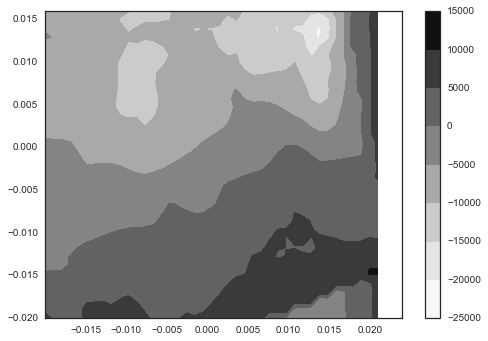

In [124]:
plt.contourf(mesh_wo_edges[0][:, :, 0], mesh_wo_edges[1][:,:, 0],
             u_i_z_all_planes[:, :, 0])
plt.colorbar()

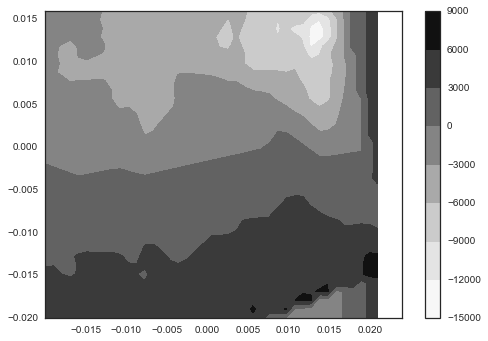

In [126]:
plt.contourf(mesh_wo_edges[0][:, :, 0], mesh_wo_edges[1][:,:, 0],
             u_i_z_all_planes[:, :, 53])
plt.colorbar()

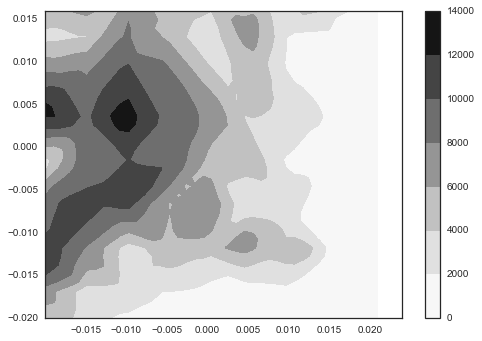

In [127]:
plt.contourf(mesh_wo_edges[0][:, :, 0], mesh_wo_edges[1][:,:, 0],
             u_i_z_all_planes[:, :, -1])
plt.colorbar()

In [110]:
time_point = 249

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mesh_wo_edges = wcf.remove_edges_mesh([np.array(mesh[0]), 
                                       np.array(mesh[1]), 
                                       np.array(mesh[2])])
ones = np.ones(mesh_wo_edges[0].shape)


te_interpolator = te_interpolators[time_point]
n_interpolator = n_interpolators[time_point]
    
temperature = wcf.scalar_on_mesh(te_interpolator, mesh_wo_edges)
density = wcf.scalar_on_mesh(n_interpolator, mesh_wo_edges)
b_field, b_field_norm = wcf.b_field_on_mesh([bx_interpolators[time_point], 
                                             by_interpolators[time_point],
                                             bz_interpolators[time_point]], 
                                             mesh_wo_edges, 
                                             bias=2e-2)

(x_min, x_max, 
 y_min, y_max,
 z_min, z_max) = wcf.joint_mach_bdot_tp_extent()

spatial_increment = 0.001
mesh = np.meshgrid(np.linspace(x_min, x_max, np.ceil((x_max-x_min)/spatial_increment)),
                   np.linspace(y_min, y_max, np.ceil((y_max-y_min)/spatial_increment)),
                   np.linspace(z_min, z_max, np.ceil((z_max-z_min)/spatial_increment)))

mach_y_interpolator = mach_y_interpolators[time_point]
mach_z_interpolator = mach_z_interpolators[time_point]
te_interpolator = te_interpolators[time_point]
 
mach_y = wcf.scalar_on_mesh(mach_y_interpolator, mesh[:2])
mach_z = wcf.scalar_on_mesh(mach_z_interpolator, mesh)
te = wcf.scalar_on_mesh(te_interpolator, mesh)
#te = wcf.boxcar_filter_quantity_mesh(te, 15)

u_i_y = np.sqrt(te*q_e/m_i)*mach_y
u_i_z = np.sqrt(te*q_e/m_i)*mach_z

u_i_y = np.reshape(u_i_y, mesh[0].shape)
u_i_z = np.reshape(u_i_z, mesh[0].shape)

u_i_y = wcf.remove_edges_scalar_quantity_meshes(u_i_y)
u_i_z = wcf.remove_edges_scalar_quantity_meshes(u_i_z)

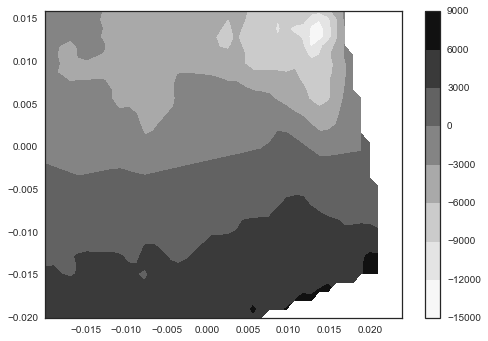

In [111]:
plt.contourf(mesh_wo_edges[0][:, :, 0], mesh_wo_edges[1][:,:, 0],
             u_i_z[:, :, 53])
plt.colorbar()

In [ ]:
u_i_z[:, :, 53]

In [117]:
averages = np.nanmean(u_i_z[:,:,53], axis=0)

In [120]:
u_i_z_test = np.where(np.isnan(u_i_z[:, :, 53]), averages, u_i_z[:, :, 53])

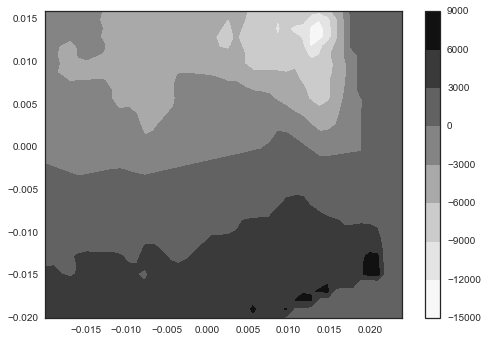

In [122]:
plt.contourf(mesh_wo_edges[0][:, :, 0], mesh_wo_edges[1][:,:, 0],
             u_i_z_test)
plt.colorbar()

# Try just using the Mach measurements from z=40cm plane and just adjusting temperature to get the propagate along planes

In [141]:
timesteps = 250

database = '/home/jensv/rsx/jens_analysis/shots_database/source/shots.db'
table = 'Shots'
z_direction_1, z_direction_2 = 0, 180
y_direction_1, y_direction_2 = 90, 270
angle_signs = {0: 1,
               180: -1,
               90: -1,
               0: 1}
min_spectral_density = 1.6e-8

condition_z_0416 = ("campaigns = 'mach_probe_plane_campaign_1'"
                    " AND fiducial_pre_crowbar_gyration_spectral_density > "
                    + str(min_spectral_density) +
                    " AND mach_signals_exist = 1"
                    " AND (mach_orientation = " + str(z_direction_1) +
                    " OR mach_orientation = " + str(z_direction_2) + ")")

condition_y_0416 = ("campaigns = 'mach_probe_plane_campaign_1'"
                    " AND fiducial_pre_crowbar_gyration_spectral_density > "
                    + str(min_spectral_density) +
                    " AND mach_signals_exist = 1"
                    " AND (mach_orientation = " + str(y_direction_1) +
                    " OR mach_orientation = " + str(y_direction_2) + ")")

cursor, connection = read_from_sql.cursor_with_rows(condition_z_0416,
                                                    database,
                                                    table)
z_0416_shots = cursor.fetchall()
cursor.close()
connection.close()

cursor, connection = read_from_sql.cursor_with_rows(condition_y_0416,
                                                    database,
                                                    table)
y_0416_shots = cursor.fetchall()
cursor.close()
connection.close()

mach_z_0416_measurements = ic_to_mach.run_mach_analysis(z_0416_shots,
                                                        timesteps, 
                                                        angle_signs) 
mach_y_0416_measurements = ic_to_mach.run_mach_analysis(y_0416_shots,
                                                        timesteps, 
                                                        angle_signs)
mach_z_0302_measurements = ic_to_mach.run_mach_analysis(z_0302_shots,
                                                        timesteps, 
                                                        angle_signs)

mach_z_0416_measurements['delays'] = np.arange(timesteps)
mach_y_0416_measurements['delays'] = np.arange(timesteps)

mach_z_0416_measurements = struc_3d.average_duplicate_points(mach_z_0416_measurements)
mach_y_0416_measurements = struc_3d.average_duplicate_points(mach_y_0416_measurements)

mach_y_measurements = {0.416: mach_y_0416_measurements}
mach_z_measurements = {0.416: mach_z_0416_measurements}

mach_y_all_planes = wcf.save_quantity_to_unstructured_grids(mach_y_measurements, 
                                                            'Mach_y', 'Mach_y', '2016-07-26',
                                                            planes=[0.416],
                                                            x_min=-0.052, x_max=0.052,
                                                            y_min=-0.022, y_max=0.032, 
                                                            z_min=0.249, z_max=0.416,
                                                            bounds=(-10, 10))

mach_z_all_planes = wcf.save_quantity_to_unstructured_grids(mach_z_measurements, 
                                                            'Mach_z', 'Mach_z', '2016-07-26',
                                                            planes=[0.416],
                                                            x_min=-0.032, x_max=0.032,
                                                            y_min=-0.022, y_max=0.032, 
                                                            z_min=0.249, z_max=0.416,
                                                            bounds=(-10, 10))
mach_y_all_planes = wcf.remove_nan_points(mach_y_all_planes)
mach_z_all_planes = wcf.remove_nan_points(mach_z_all_planes)

mach_y_triangulation, mach_y_interpolators = wcf.give_delaunay_and_interpolator(mach_y_all_planes)
mach_z_triangulation, mach_z_interpolators = wcf.give_delaunay_and_interpolator(mach_z_all_planes)

te_interpolator = te_interpolators[time_point]

mach_y = wcf.scalar_on_mesh(mach_y_interpolators[time_point], mesh[:2])
mach_z = wcf.scalar_on_mesh(mach_z_interpolators[time_point], mesh[:2])
te = wcf.scalar_on_mesh(te_interpolator, mesh)

u_i_y = np.sqrt(te*q_e/m_i)*mach_y[:,:,-1][:,:, None]
u_i_y = np.reshape(u_i_y, mesh[0].shape)
u_i_y = wcf.remove_edges_scalar_quantity_meshes(u_i_y)
# add row averaging

u_i_z = np.sqrt(te*q_e/m_i)*mach_z[:,:,-1][:,:, None]
u_i_z = np.reshape(u_i_z, mesh[0].shape)
u_i_z = wcf.remove_edges_scalar_quantity_meshes(u_i_z)
# add row averaging

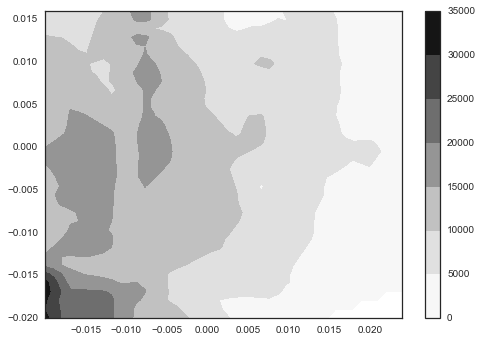

In [142]:
plt.contourf(mesh_wo_edges[0][:, :, 0], mesh_wo_edges[1][:,:, 0],
             u_i_z[:,:,0])
plt.colorbar()

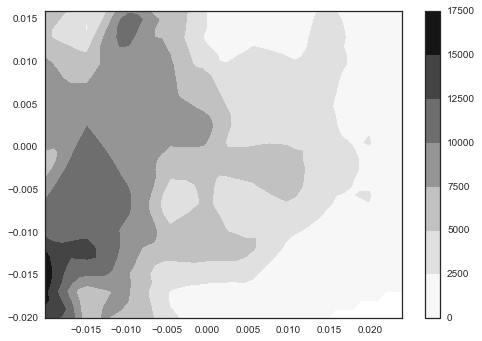

In [143]:
plt.contourf(mesh_wo_edges[0][:, :, 0], mesh_wo_edges[1][:,:, 0],
             u_i_z[:,:,-1])
plt.colorbar()

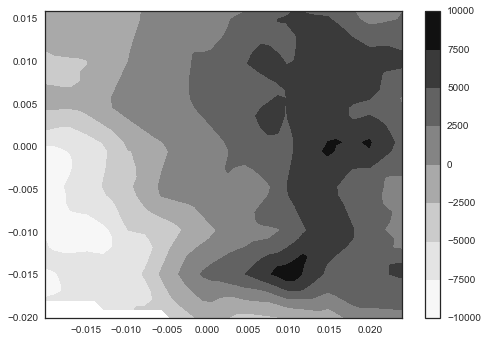

In [144]:
plt.contourf(mesh_wo_edges[0][:, :, 0], mesh_wo_edges[1][:,:, 0],
             u_i_y[:,:,0])
plt.colorbar()

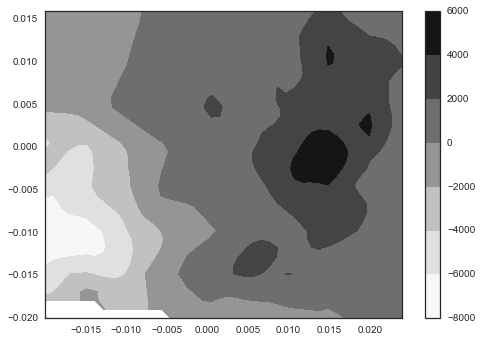

In [145]:
plt.contourf(mesh_wo_edges[0][:, :, 0], mesh_wo_edges[1][:,:, 0],
             u_i_y[:,:,-1])
plt.colorbar()